In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [4]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from gammapy.modeling.models.cube import IRFModel
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : LxgTOzmN 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 543642.26
  Predicted background counts     : 533641.14
  Predicted excess counts         : 10001.12

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2297976.73

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal 

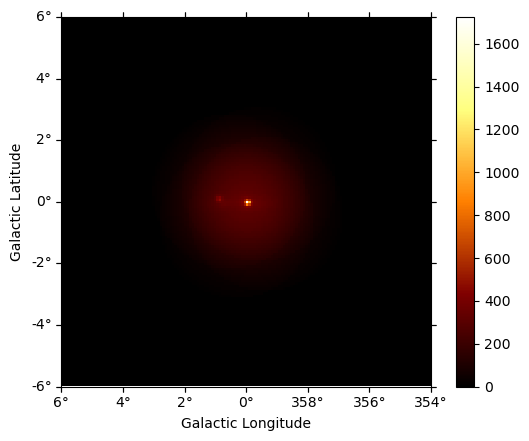

In [5]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].min = dataset_standard.models[0].parameters['lon_0'].value - 1
dataset_standard.models[0].parameters['lon_0'].max = dataset_standard.models[0].parameters['lon_0'].value + 1
dataset_standard.models[0].parameters['lat_0'].min = dataset_standard.models[0].parameters['lat_0'].value - 1
dataset_standard.models[0].parameters['lat_0'].max = dataset_standard.models[0].parameters['lat_0'].value + 1
dataset_standard.models[1].parameters['lon_0'].min = dataset_standard.models[1].parameters['lon_0'].value - 1
dataset_standard.models[1].parameters['lon_0'].max = dataset_standard.models[1].parameters['lon_0'].value + 1
dataset_standard.models[1].parameters['lat_0'].min = dataset_standard.models[1].parameters['lat_0'].value - 1
dataset_standard.models[1].parameters['lat_0'].max = dataset_standard.models[1].parameters['lat_0'].value + 1
#dataset_standard.models[0].parameters['lon_0'].frozen = True
#dataset_standard.models[0].parameters['lat_0'].frozen = True
#dataset_standard.models[1].parameters['lon_0'].frozen = True
#dataset_standard.models[1].parameters['lat_0'].frozen = True


#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

#create standard dataset with nuisance
dataset_standard_N = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
models_N = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_nuisance_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models_N.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard_N.name)
bkg_model.parameters['tilt'].frozen  = False
models_N.append(bkg_model)
#irf model
IRFmodel = IRFModel(dataset_name = dataset_standard_N.name)
IRFmodel.parameters['bias'].frozen  = True
IRFmodel.parameters['resolution'].frozen  = True
IRFmodel.parameters['tilt_nuisance'].frozen  = False
models_N.append(IRFmodel)
dataset_standard_N.models = models_N
#dataset_standard_N.models.parameters['norm_nuisance'].value  = 0.0
#dataset_standard_N.models.parameters['tilt_nuisance'].value  = 0.0
#dataset_standard_N.exposure = dataset_standard_N.npred_exposure()
zero = 1e-24
shift = 0.1
tilt = 0.015
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix


dataset_standard_N.models[0].parameters['lon_0'].min = dataset_standard_N.models[0].parameters['lon_0'].value - 1
dataset_standard_N.models[0].parameters['lon_0'].max = dataset_standard_N.models[0].parameters['lon_0'].value + 1
dataset_standard_N.models[0].parameters['lat_0'].min = dataset_standard_N.models[0].parameters['lat_0'].value - 1
dataset_standard_N.models[0].parameters['lat_0'].max = dataset_standard_N.models[0].parameters['lat_0'].value + 1
dataset_standard_N.models[1].parameters['lon_0'].min = dataset_standard_N.models[1].parameters['lon_0'].value - 1
dataset_standard_N.models[1].parameters['lon_0'].max = dataset_standard_N.models[1].parameters['lon_0'].value + 1
dataset_standard_N.models[1].parameters['lat_0'].min = dataset_standard_N.models[1].parameters['lat_0'].value - 1
dataset_standard_N.models[1].parameters['lat_0'].max = dataset_standard_N.models[1].parameters['lat_0'].value + 1
#dataset_standard_N.models[0].parameters['lon_0'].frozen = True
#dataset_standard_N.models[0].parameters['lat_0'].frozen = True
#dataset_standard_N.models[1].parameters['lon_0'].frozen = True
#dataset_standard_N.models[1].parameters['lat_0'].frozen = True

#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_standard_N.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
print(dataset_standard_N)

## Varying the Exposure

In [6]:
savefig = True
picformat = 'svg'
shift = 0.10 #0.085
tilt = 0.015

In [44]:
infos = np.loadtxt("data/7a2_P_draw_info.txt")
pars = np.loadtxt("data/7a2_P_draw_par.txt")
flux = np.loadtxt("data/7a2_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a2_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'lambda_', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4]
lambdas = pars[:N_max,4:6] 
norms = pars[:N_max,6:8]
tilts = pars[:N_max,8:10]


fluxpoints = []
for f in shift_rnds:
    try:
        print(f'6_fluxpoints_{f:.6}')
        ff = FluxPoints.read(f'data/fluxpoints/62_fluxpoints_{f:.6}.fits') 
        fluxpoints.append(ff)
        
    except:
        pass
print(len(fluxpoints), len(shift_rnds))    
N = len(fluxpoints)

100
6_fluxpoints_0.0368081
6_fluxpoints_0.0718419
6_fluxpoints_-0.0571522
6_fluxpoints_-0.0142583
6_fluxpoints_0.0241604
6_fluxpoints_0.242365
6_fluxpoints_-0.167055
6_fluxpoints_-0.0339091
6_fluxpoints_0.042743
6_fluxpoints_-0.0186321
6_fluxpoints_0.0355775
6_fluxpoints_0.0831866
6_fluxpoints_0.140661
6_fluxpoints_0.103227
6_fluxpoints_0.0322793
6_fluxpoints_0.0230203
6_fluxpoints_-0.00612031
6_fluxpoints_0.0187252
6_fluxpoints_0.202061
6_fluxpoints_-0.110102
6_fluxpoints_0.120432
6_fluxpoints_-0.0685957
6_fluxpoints_0.0300584
6_fluxpoints_0.0381599
6_fluxpoints_0.0527719
6_fluxpoints_0.0957554
6_fluxpoints_0.0436558
6_fluxpoints_-0.124071
6_fluxpoints_0.122179
6_fluxpoints_-0.0580368
6_fluxpoints_-0.00031324
6_fluxpoints_-0.0690507
6_fluxpoints_-0.0594054
6_fluxpoints_-0.132591
6_fluxpoints_-0.036753
6_fluxpoints_0.0426186
6_fluxpoints_0.0522452
6_fluxpoints_-0.0415699
6_fluxpoints_-0.135973
6_fluxpoints_0.0715897
6_fluxpoints_-0.00916537
6_fluxpoints_-0.180819
6_fluxpoints_-0.037631

In [7]:
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_standard])

fit_cor_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor_N.backend = "minuit"
fit_cor_N.optimize_opts = minuit_opts
result_cor_N = fit_cor_N.run([dataset_standard_N])

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [8]:
dataset_standard_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_standard_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [9]:
mask = dataset_standard.mask.data[:,60,60]
ebins = dataset_standard.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

(-0.26453351559287286, 0.26453351559287286)

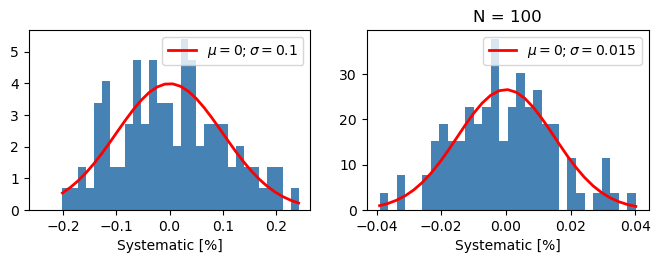

In [45]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color = 'steelblue')
sigma =shift
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color = 'steelblue')
sigma =tilt
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)

## Compute Asimov Fluxpoints

does not work because of the is_norm in the model

In [46]:
fluxpoints_standard_N = FluxPoints.read("data/6b_fluxpoints_standard_N.fits")
fluxpoints_standard = FluxPoints.read("data/6b_fluxpoints_standard.fits")
fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits")
fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits")

In [47]:
energy_edges = dataset_standard.geoms['geom'].axes[0].edges

In [48]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

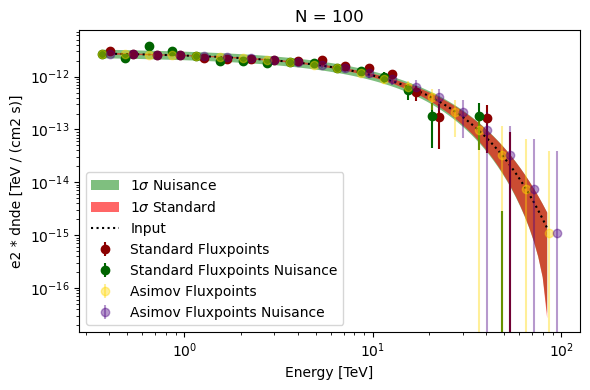

In [49]:
fig, axs = plt.subplots(1,1, figsize = (6,4))
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_standard, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o', label = 'Standard Fluxpoints')  

e_, f_, ferr_ = plot_shifted(fluxpoints_standard_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o', label = 'Standard Fluxpoints Nuisance') 


e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'gold', fmt='o', alpha = 0.4, label = 'Asimov Fluxpoints')

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'indigo', fmt='o', alpha = 0.4, label = 'Asimov Fluxpoints Nuisance') 

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
axs.legend()
axs.set_title(f"N = {N}")
plt.tight_layout()
fig.savefig(f"plots/7d2_fluxpoints_standard_asimov_{shift}_{tilt}_{N}." + picformat)

In [50]:
mask2 = fluxpoints[0].ts.data[:,0,0].data > 4
mask2

fluxpoints[0].ts.data[:,0,0].mask = mask2

In [51]:
e2dnde = []

for f in fluxpoints:
    mask2 = f.ts.data[:,0,0].data > 4
    e2dnde.append(f.e2dnde.data[:,0,0])
e2dnde = np.array(e2dnde)   

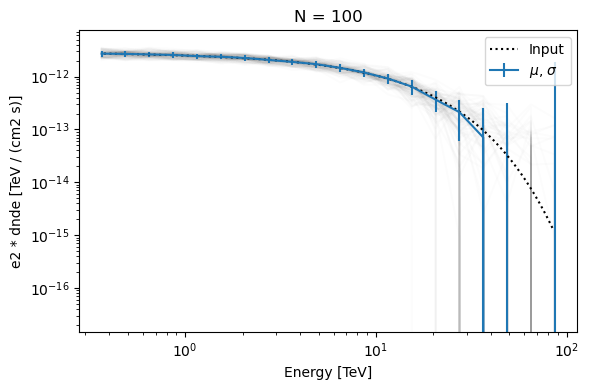

In [52]:
fig, axs1 = plt.subplots(1,1,figsize = (6,4) )
for f,e  in zip(fluxpoints,e2dnde):
    axs1.plot(f.energy_ref* 1.0, e    , color = 'black', alpha = 0.01)
    
axs1.errorbar(f.energy_ref, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
              label = "$\mu$, $\sigma$"
            )

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs1,
                                label = "Input", color = "black", )
ylim = axs.get_ylim()
axs1.set_ylim(ylim[0], ylim[1])
axs1.loglog()
axs1.set_title(f"N = {N}")
axs1.legend()
plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7d2_fluxpoints_rnd_{shift}_{tilt}_{N}." + picformat)


In [53]:
def fraction_within_e(lower_lim, upper_lim, data):
    withine = []
    for ie in range(len(lower_lim)):
        xs = []
        for f in data:
            value = f[ie]   
            lowerlim = (np.all(value >= lower_lim[ie]))
            upperlim = (np.all(value <= upper_lim[ie]))
            x = lowerlim & upperlim
            xs.append(x)
        withine.append(np.count_nonzero(xs) / len(data))
    withine  = np.array(withine)
    return withine[withine>0] 

In [54]:
e_, f_, ferr_ = plot_shifted(fluxpoints_standard, 1.05)
within_e = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)

e_, f_, ferr_ = plot_shifted(fluxpoints_standard_N, 1.05)
within_eN = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)
within_eN

array([0.51, 0.22, 0.03, 0.24, 0.64, 0.2 , 0.46, 0.45, 0.63, 0.54, 0.65,
       0.67, 0.68, 0.56, 0.42, 0.01, 0.58, 0.26, 0.09, 0.07])

In [55]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)
p = compute_precision(N)

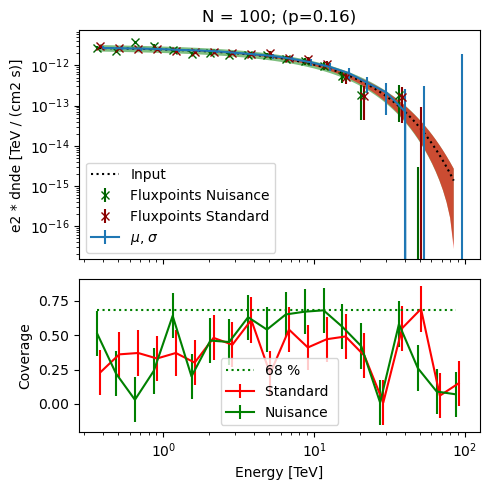

In [58]:
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))

dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "green", alpha = 0.5)    
    
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

e_, f_, ferr_ = plot_shifted(fluxpoints_standard_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='x', label = "Fluxpoints Nuisance")  

e_, f_, ferr_ = plot_shifted(fluxpoints_standard, 1.05)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='x', label = "Fluxpoints Standard")  



axs.errorbar(f.energy_ref* 1.1, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
                 label = "$\mu$, $\sigma$")


ax2.errorbar(ebins*1.05, within_e, yerr=p,color = 'red', label = f"Standard ")
ax2.errorbar(ebins, within_eN,yerr=p, color = 'green', label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'green', label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend()
axs.set_title(f"N = {N}; (p={p:.2})")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage')

axs.set_xlabel('')
axs.legend()

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7d2_fluxpoints_coverage_{shift}_{tilt}_{N}." + picformat)
